In [1]:
# there no change change in the first several cells from last lecture (makemore3)

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [5]:
# read in all the words
words = open('names4.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# ok biolerplate done, now we get to the action:

In [9]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [10]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [11]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
# create a list with random integers between 0 and size of list of examples with lenght batch_size 
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
print(Xtr.shape)
print(Ytr.shape)
print(ix)

# create the input set Xtr and the expected output set Ytr 
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
# 32x3
print(Xb.shape)
Xb[:5]

torch.Size([182625, 3])
torch.Size([182625])
tensor([120000, 157809,  82137,  69514,  73004,  68734,    286, 123947,  13538,
         42674, 165010,  81021,  59151,  46471,  62456,  64636,  24418, 108817,
        169833, 145683, 168275, 157689,  36258, 142280,  32537, 149713, 149734,
        149517, 165139, 153533,  89661,  20039])
torch.Size([32, 3])


tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])

In [12]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
# logits = 32x27 (batch exmaples x character predictions)
logits = h @ W2 + b2 # output layer


# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()

# n is batch_size
# logprobs = 32x27
# we create a list 0-26 and pick each row of the 32 batches which represent our context input ['.','.','.'] 
# we look at our Yb vector tensor([ 1,  5,  0, 25, 11, 15,  5,  0, 12, 19, 20, 19,  0,  5,  1,  5, 15,  9,
         #1, 12,  9, 18,  0,  4,  8,  1, 18, 18,  3, 16,  5, 14])
# it tells us the expected value for each example 
# we pick all the losses for each expected values logprobs[range(n), Yb] and calulate the mean of those 32 losses 
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3666, grad_fn=<NegBackward0>)

In [13]:
# in the forward pass we only need the values but during backpropagation we also need the indices 
logits.max(1, keepdim=True)

torch.return_types.max(
values=tensor([[1.0158],
        [0.9464],
        [1.1544],
        [0.6385],
        [1.6414],
        [0.9677],
        [0.6880],
        [1.4451],
        [1.1175],
        [1.0273],
        [1.7117],
        [2.0128],
        [1.1915],
        [0.7987],
        [0.5485],
        [0.7878],
        [1.0019],
        [0.7597],
        [1.1915],
        [0.7778],
        [0.7023],
        [0.9394],
        [1.1915],
        [1.3153],
        [1.4770],
        [0.9868],
        [1.3090],
        [1.0393],
        [0.8463],
        [0.6658],
        [1.0241],
        [0.9384]], grad_fn=<MaxBackward0>),
indices=tensor([[ 1],
        [ 2],
        [19],
        [ 4],
        [15],
        [25],
        [16],
        [ 3],
        [19],
        [ 8],
        [15],
        [ 3],
        [22],
        [18],
        [ 7],
        [ 5],
        [ 2],
        [ 1],
        [22],
        [19],
        [15],
        [19],
        [22],
        [22],
        [23],
        [

torch.Size([32, 27])

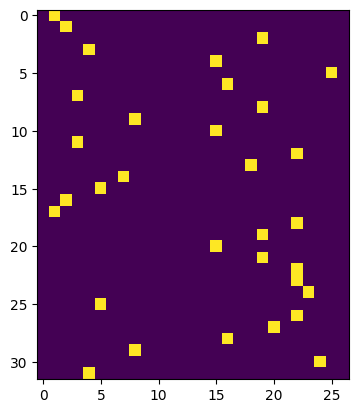

In [14]:
# okay!! we only want to backropagate the gradients of those max values, so we multiply them with one
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))
F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]).shape

In [82]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# we want to calculate the first gradient: loss = -logprobs[range(n), Yb].mean()
# loss = -(a+b+c)/3 , actually it's th sum of 32 values /32 
# loss = -1/3a -1/3b -1/3c
# what is dloss/da = ? -1/3

# with 32 elements dloss/da = -1/n
# dloss/db = -1/n
# dloss/dc = -1/n

# !!! this means we need to update each value we select with this logprobs[range(n), Yb] to -1/n !!!!! 

# dloss/dlogprobs = ? 
# creates a tensor of the same same shape like logprobs
dlogprobs = torch.zeros_like(logprobs)

dlogprobs[range(n), Yb] = -1.0/n 
cmp('logprobs', dlogprobs, logprobs)

# second gradient 
# logprobs = probs.log()
# dloss/dlogprobs * dlogprobs/dprobs (chain rule)
# mdlogprobs/dprobs = ? logprobs = log(probs) -> 1/probs
dprobs = (1.0/probs) * dlogprobs # (chain rule)
cmp('probs', dprobs, probs)

# third gradient 
# probs = counts * counts_sum_inv
# dprobs/ counts = ? counts_sum_inv
# dprobs/ counts_sum_inv = ? counts
# dloss/counts = dloss/dlogprobs * dlogprobs/dprobs * dprobs/counts 
# dloss/counts_sum_inv = dloss/dlogprobs * dlogprobs/dprobs * dprobs/counts_sum_inv

#### caution here because we backpropagrate through tensors of different sizes 
print('')
print('#### caution here because we backpropagrate through tensors of different sizes ')

# but we have to take care of the different shapes 
# counts.shape: 32x27, counts_sum_inv: 32x1, dprobs.shape: 32x27
print('counts.shape:', counts.shape, 'counts_sum_inv', counts_sum_inv.shape, 'dprobs: ', dprobs.shape)

# counts and dprobs are the same size this is okay but counts_sum_inv is only 32x1
# this means we have transform the resulting 32x27 matrix of our multiplication to a 32x1 vector.

# with keepdim=False this would procduce a 1-dimensional list 
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # chain rule, sum is because of the dimension differences
print('dcounts_sum_inv: ', dcounts_sum_inv.shape)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

# count_sum_inv.shape = 32x1, dprobs.shape = 32x27, counts.shape = 32x27
print('count_sum.inv.shape: ', counts_sum_inv.shape, 'dprobs: ', dprobs.shape, 'counts.shape: ', counts.shape,)

# here again we need to check the shape of our resulting maltrix 'dcounts' after the multiplication 
# equals the shape of 'counts'
# here we will see implicite broadcasting count_sum_inv.shape 32x1 will be copied on the 1-dimension 27 times 

dcounts = counts_sum_inv * dprobs # we cannot check this immediatly we nee to calculate a second branch first  

# fourth gradient
# counts_sum_inv = counts_sum**-1
# dcounts_sum_inv/dcounts_sum = ? -1.0/(counts_sum**2)

#dloss/dcounts_sum = ? 
dcounts_sum = (-1.0/(counts_sum**2)) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)
print('dcounts_sum.shape', dcounts_sum.shape )

# now we can caluculate dcounts because it is used twice to value befor was just the first part of the calculation 
# counts_sum = counts.sum(1, keepdims=True)
# dcounts_sum/ dcounts = ? 
# counts is 32x27, dcounts_sum 32x1
# plus operation does nothing it just routes backpropagates the gradient without doing anything
# so we just created a tensor of ones 
dcounts += torch.ones_like(counts) * dcounts_sum  # += because we already calculated the first part above: dcounts = counts_sum_inv * dprobs
cmp('counts', dcounts, counts)

#counts = norm_logits.exp()
dnorm_logits = norm_logits.exp() * dcounts # f'(e^x) = e^x
cmp('norm_logits', dnorm_logits, norm_logits)


# norm_logits = logits - logit_maxes
# dnorm_logits/dlogits = ? 1.0 , simple rules like f(x,y)= x+y -> d(x,y)/dx = 1 
# dnorm_logits/logit_maxes = ? -1.0 
# norm_logits.shape:  torch.Size([32, 27]) logits:  torch.Size([32, 27]) logit_maxes:  torch.Size([32, 1])
#32x1
dlogit_maxes = -(dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

dlogits = dnorm_logits.clone() # differentiation was just 1.0 so we can just pass through the gradient 
# dlogit is calulcated in multiple lines so we have to look further before we can compare the gradient 

# logit_maxes = logits.max(1, keepdim=True).values
# dlogit_maxes/dlogits = ? 
# logit_maxes : torch.Size([32, 1]) logits:  torch.Size([32, 27])
# okay!! we only want to backropagate the gradients of those max values, so we multiply them with one
# 32x27 = 32x27 *32x1 , this is brosadcast magic, dlogit_maxes will be replecated 27 times in the 0-dimension (columns)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes 
cmp('logits', dlogits, logits)

# logits = h @ W2 + b2 # output layer
# the b2 will be replicated 32 time (by row via broadcasting resulting in an 32x27 tensor)
# logits: torch.Size([32, 27]) = h: torch.Size([32, 64]) @ W2: torch.Size([64, 27]) + torch.Size([27])

# in the picture we can see that the differentiation of a_11 is just the differentiation of the single values of [dL/d_11, ..]: logits * b_transposed

# long story short the backward pass of a matrix multiplication is a matrix multiplication and can be calculated 
# dlogits/dh = ? dlogits *W2.T  #dlogits is already what we are lookging for (dlogits/dd *b^T)
# 32x64 = 32x27 @ 27x64 , ->>>> 64x27^T = 27x64, this works 
dh = dlogits@W2.T
cmp('h', dh, h)

# dL/dW2 = h^T @  dlogits
# 64x27 = 64x32 @ 32x27, that looks perfect, see photo below 
dW2 =  h.T @dlogits
cmp('W2', dW2, W2)

#dL/db2 = dlogits.sum(0), 0-dimensione, see photo below 
db2= dlogits.sum(0)
cmp('b2', db2, b2)

# h = torch.tanh(hpreact) # hidden layer
# dh/dhpreact =  (1 - hpreact**2)  *dh 

#caution da/dz = 1-a^2, so we use the output of the tanh not the input, that is why we use h instead of hpreact
dhpreact= (1.0 - h**2)  *dh 
cmp('hpreact', dhpreact, hpreact)

# hpreact = bngain * bnraw + bnbias
# dhpreact/bngain =  ? bnraw
# dhpreact/bnraw = ? bnggain
# dhpreact/bnbias = ? bnbias
#print(bngain.shape, bnraw.shape, dhpreact.shape)
# torch.Size([1, 64]) = torch.Size([32, 64]) * torch.Size([32, 64])
dbngain =  (bnraw * dhpreact).sum(0, keepdim=True) # size for the multiplication is cool but we need to sum the match the shape of bngain !!
cmp('bngain', dbngain, bngain)

#  torch.Size([1, 64]) =  torch.Size([32, 64])
dbnbias = dhpreact.sum(0, keepdim= True)
cmp('bnbias', dbnbias, bnbias)

#torch.Size([32, 64]) = torch.Size([1, 64]) * torch.Size([32, 64])
dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)

# bnraw = bndiff * bnvar_inv
#torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([1, 64])
#dbnraw/bndiff = ? bnvar_inv
#dbnraw/bnvar_inv = ? bndiff
# 1x64 = 32x64 * 32x64
dbnvar_inv = (bndiff*dbnraw).sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

# bnvar_inv = (bnvar + 1e-5)**-0.5
# /dbnvar_inv/dbnvar = ?  
# torch.Size([1, 64]) =  torch.Size([1, 64]) + torch.Size([1, 64])
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

# we dig again in the batch normalization paper (mini-batch variance)
# the problem was that they use two diffrent formulas on during traning and another one during varifying the results of the training set 
# Andrej says this is a bug in his eyes and he prefers to only use on formular for both situtations 
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# torch.Size([1, 64]) torch.Size([32, 64])


# if we have a sum in the forward pass we will have a replication in the backward pass
# if we have a replication in the forward pass we will have a sum in the backward pass 

#dbnvar/bndiff2 = ? 
#32x64 = 1/(n-1) * 1x64
dbndiff2 = ((1/(n-1))*torch.ones_like(bndiff2)) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

#torch.Size([32, 64]) torch.Size([32, 64])
#bndiff2 = bndiff**2
# caution 
dbndiff += (2*bndiff) * dbndiff2
cmp('bndiff', dbndiff, bndiff)

# bndiff = hprebn - bnmeani
# torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([1, 64])
#32x64 = 1.0 * 32x64
dhprebn = dbndiff.clone()
# we have another step for dhprebn

#1x64 = 32x64
dbnmeani = -(dbndiff).sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# torch.Size([1, 64]) torch.Size([32, 64])
#32x64 
dhprebn += ((1/n)*torch.ones_like(dhprebn)) * dbnmeani
cmp('hprebn', dhprebn, hprebn)

# hprebn = embcat @ W1 + b1 # hidden layer pre-activation
#print(hprebn.shape, embcat.shape, W1.shape, b1.shape)
#torch.Size([32, 64]) torch.Size([32, 30]) torch.Size([30, 64]) torch.Size([64])
#32x30 = 32x64  @64x30 (transposed)
dembcat = dhprebn@W1.T 
cmp('embcat', dembcat, embcat)

#30x64 = 30x32@32x64
dW1 = embcat.T@dhprebn
cmp('W1', dW1, W1)

#32x1 = 32x46
db1 = dhprebn.sum(0)
cmp('b1', db1, b1)

# embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
#print(embcat.shape, emb.shape)
# torch.Size([32, 30]) torch.Size([32, 3, 10]) 
# just re-view it there is no operation here 
demb = dembcat.view([32, 3, 10])
cmp('emb', demb, emb)

# emb = C[Xb] # embed the characters into vectors
#print(emb.shape, C.shape)
#torch.Size([32, 3, 10]) torch.Size([27, 10])
# we need to undo the indexing 
dC= torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0

#### caution here because we backpropagrate through tensors of different sizes 
counts.shape: torch.Size([32, 27]) counts_sum_inv torch.Size([32, 1]) dprobs:  torch.Size([32, 27])
dcounts_sum_inv:  torch.Size([32, 1])
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
count_sum.inv.shape:  torch.Size([32, 1]) dprobs:  torch.Size([32, 27]) counts.shape:  torch.Size([32, 27])
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum.shape torch.Size([32, 1])
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  |

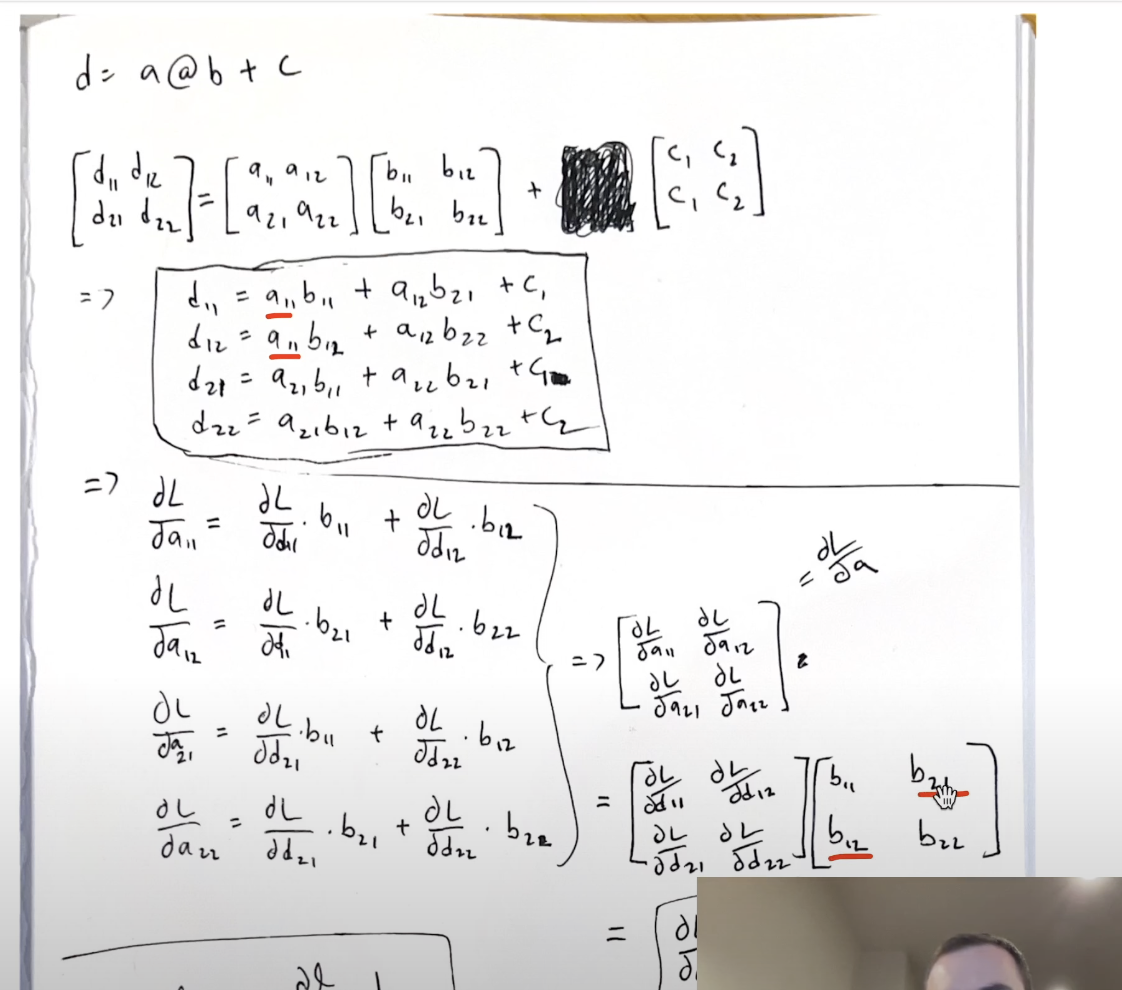

In [29]:
from IPython.display import Image

Image("Bildschirmfoto 2023-08-28 um 21.22.00.png")

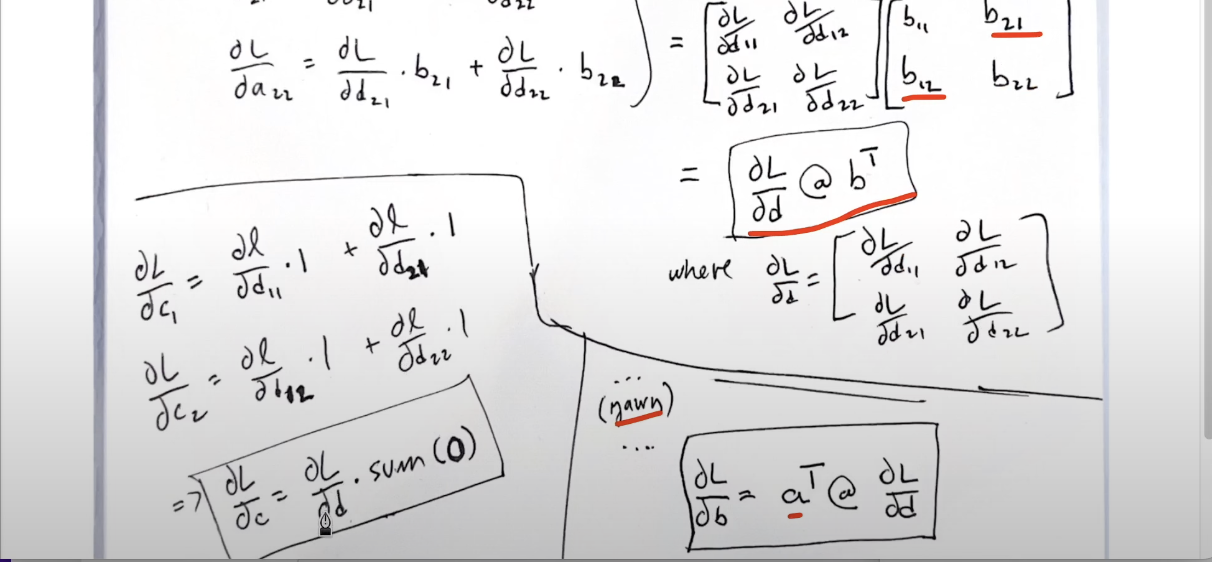

In [28]:
Image("Bildschirmfoto 2023-08-28 um 21.25.17.png")

In [83]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

In [84]:
# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())


3.3666372299194336 diff: -2.384185791015625e-07


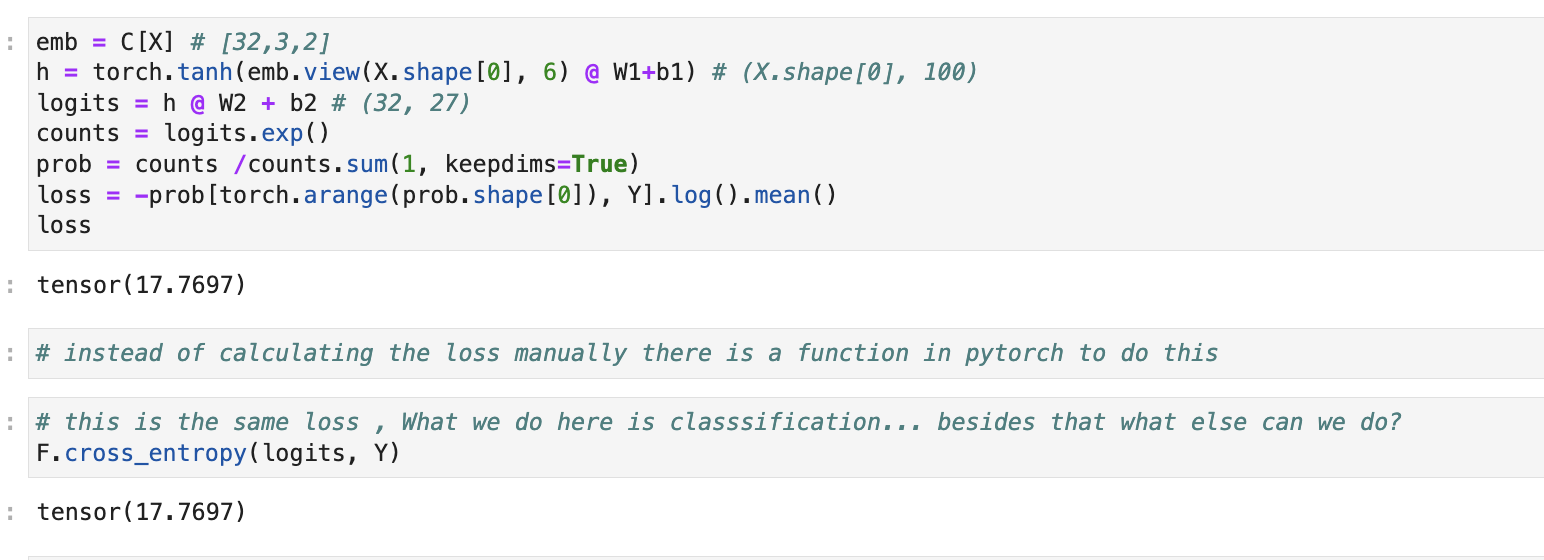

In [86]:
Image("Bildschirmfoto 2023-08-30 um 16.30.31.png")
# refresher about F.cross_entropy(logits, Y)
# this function is more efficint to calculate the loss from our logits with repect to the expected values Y
# otherwise we would have to calculate everthing on our own

In [87]:
# in exercise 2 we want to understand how to backpropagrate through the F.cross_entropy function 

In [88]:
# counts and probs together are called softmax ... softmax calculates the .exp() + the avg with respect to each row -> sum of row is 1 after this opperation 
# we use softmax with respect to logits to calculate the probalities in the last layer to predict stuff 
# probs = F.softmax(logits, dim=1)

In [89]:
# logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

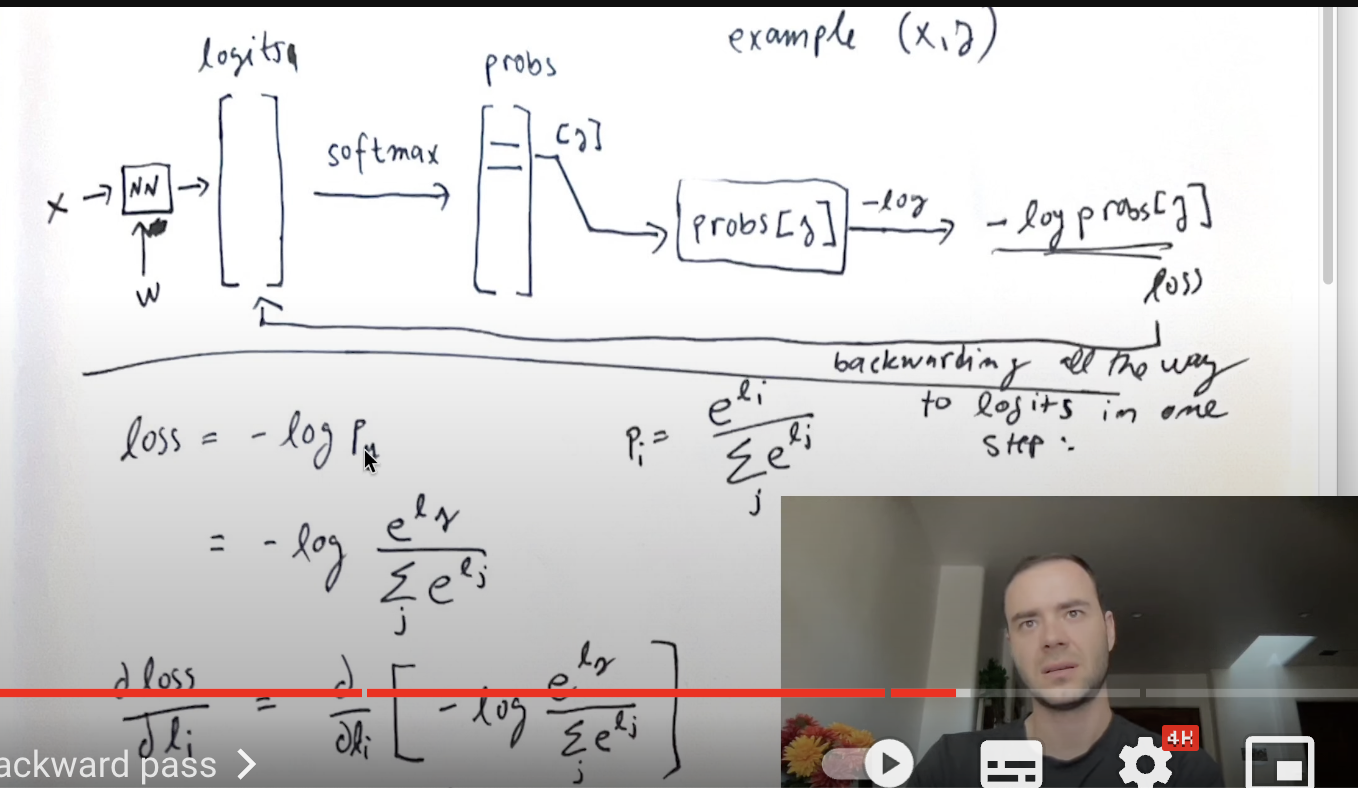

In [90]:
Image("Bildschirmfoto 2023-08-30 um 16.58.41.png")

In [91]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


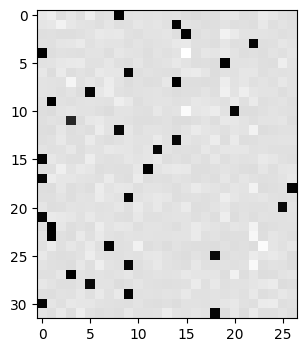

In [92]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [110]:
F.softmax(logits, 1)[0]

tensor([0.0630, 0.0884, 0.0199, 0.0507, 0.0206, 0.0867, 0.0236, 0.0348, 0.0176,
        0.0313, 0.0377, 0.0348, 0.0383, 0.0297, 0.0316, 0.0135, 0.0087, 0.0198,
        0.0158, 0.0521, 0.0535, 0.0222, 0.0265, 0.0738, 0.0559, 0.0273, 0.0221],
       grad_fn=<SelectBackward0>)

In [102]:
F.softmax(logits, 1)[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [113]:
dlogits[4] * n

tensor([-0.9851,  0.0159,  0.0279,  0.0235,  0.0193,  0.0418,  0.0378,  0.0169,
         0.0518,  0.0392,  0.0337,  0.0149,  0.0379,  0.0236,  0.0436,  0.1665,
         0.0186,  0.0523,  0.0472,  0.0632,  0.0419,  0.0153,  0.0232,  0.0144,
         0.0429,  0.0260,  0.0458], grad_fn=<MulBackward0>)

In [99]:
# we interprete the dlogits 
# You can think of this gradients here like as a force 
# we want to pull down weights of the incorrect characters and we are pulling up  the weights of the correct characters  
# the sum of those gradients is 0 
# if the pobalities woudl be perfect we would see zero everywhere expect for on value, this value would be one 
# all the dlogits with respect to the perfect probs row woudl be zero 
dlogits[0].sum() # it's zero 


tensor(-9.3132e-10, grad_fn=<SumBackward0>)